# Optimized Model
This model does not show under- or overfitting and performs well on both, training and testing data. Afterwards, a brief description on how to tackle the challenges of an optimal model complexity. 

To address underfitting, one approach is to increase the complexity of the model by adding more layers or increasing the number of filters in each layer. To address overfitting, we can try several approaches. One approach is to simplify the model by removing some layers or decreasing the number of filters in each layer. Another approach is to use less epochs for example.




Adding dropout or weight decay can help to address both of the above mentioned issues. We can also try adjusting the hyperparameters such as learning rate, batch size, or number of epochs.

## GPU Acceleration
We found out that training a model on images can be a very time consuming task, especially if many images are involved. Randomly we stumbled upon an article that stated about "GPU Acceleration" which sounded pretty interesting. Afterwards, we read a bit about the topic and found out that it is possible on our Apple M1 Pro / M2 Pro chips. After a lot of trial and error we ended up using the tensorflow-macos and tensorflow-metal packages but with specific versions because the newest versions did not work. With the both packages installed correctly, both the CPU and GPU are being used for training. The CPU on the M2 Pro chip has 12 cores and a 19 core GPU. The total of 31 cores over 12 cores already indicates that usage of the GPU would lead to massive performance improvements. The following image shows the CPU and GPU usage during training of the optimized model:
![GPU Acceleration](gpu-acceleration.png "GPU Acceleration")

When we were utilizing the CPU only training took ~100s per epoch for the overfitting model (~11'000'000 trainable parameters). After enabling GPU acceleration we came down to astonishing ~10s per epoch. This factor of 10 improvement was even more than we hoped and enabled us to test more parameters because training took about 2 minutes instead of the usual 20 minutes.

## Dataset Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4309275832134404310
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 17627156154337262148
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB




2023-03-14 11:09:20.996751: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-14 11:09:20.996897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Data Augmentation
Data Augmentation has proven to be a useful tool for model generalization. We've compared the same model with and without data augmentation and the results show that the model without data augmentation tends to overfit while the model with data augmentation doesn't:
![Data Augmentation Result](comparison-data-agumentation.jpg "Data Augmentation Result")

During this project we've also encountered some downsides of data augmentation. One apparent downside is that it drastically slows down the training because the images are being preprocessed. Another downside is that data augmentation somehow fails in combination with GridSearchCV which we've encountered only accidentially and already thought that our model is the problem why the learning curve converged in the second step at an accuary of 0.2.

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

img_size = 150
batch_size = 32
seed = 31

train_ds = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    validation_split=0.2,
    subset="training",
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)
val_ds = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)
test_ds = image_dataset_from_directory(
    './dataset/seg_test/seg_test',
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 2666 files belonging to 5 classes.
Using 2133 files for training.
Found 2666 files belonging to 5 classes.
Using 533 files for validation.


2023-03-14 11:09:24.724010: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-14 11:09:24.724037: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2499 files belonging to 5 classes.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomRotation, RandomZoom, Rescaling, RandomFlip

data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

2023-03-14 11:09:28.971437: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


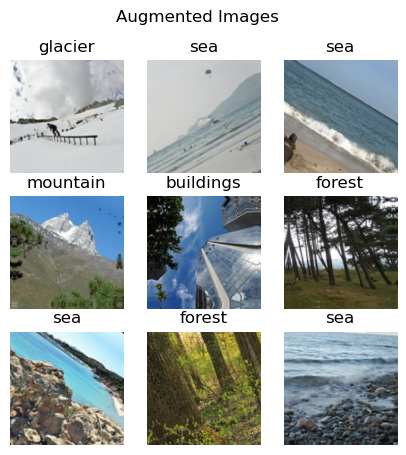

In [4]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea']
def plot_images(title, augment = False):
  plt.figure(figsize=(5, 5))
  plt.suptitle(title)
  for images, labels in train_ds.take(1):
    for i in range(9):
      augmented_images = data_augmentation(images) if augment else images
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

plot_images("Augmented Images", augment=True)

## Building the Model
As a baseline we used the same model as the overfitting one but we add some extras to reduce the overfitting behavior.

### Regularization
Regularization is used to reduce the impact impact of the weights. The weights then end up having less impact on the loss function which determines the error between the actual label and predicted label. This reduces complexity of the model and therefore reduces overfitting. We are adding regularization only to those layers which have the largest number of parameters according to the model summary. We are using L2 (Ridge) regularization since it predetermined from the task. We are adding L2 mainly to the layers that add the most parameters to the CNN.

Dropout Layers: The benefit of using dropout is no node in the network will be assigned with high parameter values, as a a result the parameter values will be dispersed and the output of the current layer will not depend on a single node.
E.g. Dropout(0.2) drops the input layers at a probability of 0.2. Dropout is applied per batch size, so the parameters get tuned for a full batch size with missing input parameters which results in lower generalization errors. 

### Generalization
To improve generalization of the model, data augmentation is a useful tool. With data augmentation we can add artificial effects to the images such as flipping and rotating. Through these effects, the images always appear differently each time they appear in the training step and therefore the CNN doesn't adapt to the exact images but rather learns about the relative features inside of an image.

### Optimizer
For the optimized model we chose Adam over the competitors because it is the most common among SGD. We tried out SGD but it performed very poorly compared to Adam which might be due to insufficient configuration of the learning rate. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order (mean) and second-order (uncentered variance) moments. Its default implementation already provides a form of annealed learning, beta_1=0.9 for the first-order moment and beta_2=0.999 for the second-order moment. 

### Activation Function
The [following article](https://thangasami.medium.com/cnn-and-ann-performance-with-different-activation-functions-like-relu-selu-elu-sigmoid-gelu-etc-c542dd3b1365) states that ReLU is the overall the best suited activation function so based on this we decided to use ReLU for our optimized model.

### Batch Size
The batch size defines how many samples (images here) run through the Neural Network before the weights get adapted. It is recommended to use mini batches to update the Neural Network multiple times during an epoch. We've tried out differnt batch sizes with the same seed on the image generator TODO

## Layers
### First Layer
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network because in general, the input values should be small. Therefore we use the Rescaling layer as a normalization layer. 

### Dropout
With Cross-Validation we've tried out different dropout params (0.2, 0.3, 0.4) for the layer before the dense layers. The results are pretty similar but the 0.3 dropout seems to be more stable at the end of 30 epochs so we used this parameter for the model. The steep spikes of accuracy in the first few epochs are expected because due to dropout, some parameters are missing everytime and the model improves a lot over a short period of time because other parameters are being dropped out at every epoch. 
![Last Layer Dropout](history-data/dropout-param-5fold-cv.png "Last Layer Dropout")

### Last Layer
For the last layer we tried out 512, 1024 and 2048 trainable parameters and the Cross-Validation result was that the accuracy and loss were not drastically affected but the network with 2048 parameters in the last layer was much more stable than the others. Based on this fact, we sticked with using 2048 parameters in the last layer.
![CV Last Layer](history-data/last-layer-param-5fold-cv.png "CV Last Layer")

### Loss Function
Because we use the SoftMax activation function as the output of the last Dense Layer, we get normalized probabilites, [0, 1]. The SparseCategoricalCrossentry function's from_logits=True would expect Logits which are in the range of [-inf, +inf] and therefore, we use from_logits=False.¨

As the optimizer, we also tried out SGD with annealed learning but in the course of 20 epochs we reached poorer results than with adam.

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

def create_model(l2_param=0.001, last_dropout_param=0.3, last_layer_param=512, augment=True):
    model = Sequential()

    if augment:
        model.add(data_augmentation)
        model.add(Rescaling(1./255))

    model.add(Conv2D(32, (3,3), input_shape= (img_size,img_size, 3), activation = 'relu', padding = 'same')) #padding = same size output
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param)))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param))) 
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))

    model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param))) 
    model.add(MaxPooling2D())

    model.add(Conv2D(last_layer_param, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param))) 
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    model.add(Dropout(last_dropout_param))
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    #model.add(Dense(512, activation='relu'))
    model.add(Dense(5, activation = 'softmax'))

    model.compile(
       optimizer = 'adam', 
       loss=SparseCategoricalCrossentropy(from_logits=False), 
       metrics=['accuracy']
    )

    return model

## Cross Validation for Parameter Optimization
For k-fold Cross Validation parameter optimization we are using a sklearn's KFold method paired with a custom functionality to fit the model with different parameter values. We tried to use GridSearchCV (as we did in the AI Foundation course) but we first thought that the model parameters (such as the regularization parameter of the 2nd Conv2D layer) are not accessible from the `param_grid` that is passed to GridSearchCV (which we later found out is not the case). We then came up with a custom KFold Cross Validation approach which is fully flexible and uses if-else statements in the model creation step. With this Cross Validation implementation we've tuned parameters such as the l2 regularization paramter, the number of trainable parameters in the last Conv2D layer or the percentage of dropout before the dense layers.

The following image visualizes the results of the l2 regularization parameter. We tested for the values 0.01, 0.001 and 0.0001 and ran a 5-fold Cross Validation with 10 epochs for each value. The regularizer is being used in three Conv2D layers of the model. As from the diagram below it is apparent that the accuracy improved the smaller the l2 regularization parameter became and, therefore, we decided to use l2=0.0001. 
![l2 Parameter Optimization](history-data/l2-param-5fold-cv.png "l2 Parameter Optimization")

### Development of the kFold CV Functionality
The part of splitting the full dataset into testing and validation data by the indices obtained by the KFold split was pretty tricky. We've encountered that it is not always convenient and easy to handle the tensorflow data. Especially without experience of the huge framework it was difficult to find information about splitting a dataset and we ended up trying out numerous ways. In the end we consulted ChatGPT which lead us in the right direction. One problem we've had is that the generated filtering functionality did not work directly and after reading the documentation of the filter method, it was not clear which parameters are being passed to this function. Also, it is surprising that tensorflow doesn't seem to have an out-of-the-box solution for such a dataset split. In the end we found out how the methods works and the implementation was successful.

The current solution is not optimal because the `.filter(... reduce_any(...))` is not performant and massively slows down the training which would be important to improve in a real project. Nevertheless, the implementation works and enabled us to make sophisticated comparisons of the model parameters. 

During the usage of the intense training functionality of KFold Cross Validation we encountered a problem using tensorflow-metal with GPU acceleration. The problem is that the python process hangs up after approximately the 8-th fold of a 10 epoch training process. This was very inconvenient because we were not able to perform the parameter optimization in one step and needed to temporarily store the results for each parameter which we made by saving the results in a JSON file. Luckily, we were able to perform the 5-fold Cross Validation of at least one parameter before the process hung up. The issue of this behavior is known but does not seem to be fixed yet, as can be seen [here]( https://developer.apple.com/forums/thread/713944). 

In [7]:
import itertools
from sklearn.model_selection import KFold
import tensorflow as tf
import json

param_grid=dict(
    # last_layer_param=[512, 1024, 2048]
    l2_param=[0.01, 0.001, 0.0001],
    augment=[False],
    # last_dropout_param=[0.2, 0.3, 0.4]
)
epochs = 30
folds = 5

keys = list(param_grid.keys())
params = list(param_grid.get(x) for x in keys)
param_permutations = list(itertools.product(*params))

model_history = dict()

dataset = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    seed=123,  # for reproducibility
    image_size=(img_size, img_size)
)

images = np.concatenate([x for x, y in dataset], axis=0)
labels = np.concatenate([y for x, y in dataset], axis=0)

kfold = KFold(n_splits=folds, shuffle=True)

for perm in param_permutations:
    model_args = dict()
    for index in range(len(params)):
        key = keys[index]
        value = perm[index]
        model_args[key] = value

    # Set title according to the params for later visualization
    title = ", ".join(list((key + ": " + str(model_args[key])) for key in model_args.keys()))
    
    print("CURRENTLY TRAINING THE MODEL WITH THE FOLLOWING PARAMS: " + title)
    model_history[title] = []

    for fold, (train_indices, val_indices) in enumerate(kfold.split(images)):
        print(f'Fold {fold+1}/{folds}, (params={title})')

        train_images, train_labels = images[train_indices], labels[train_indices]
        val_images, val_labels = images[val_indices], labels[val_indices]

        train_dataset = dataset.unbatch().filter(lambda img, label: tf.reduce_any(tf.equal(label, train_labels))).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
        val_dataset = dataset.unbatch().filter(lambda img, label: tf.reduce_any(tf.equal(label, val_labels))).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

        model = create_model(**model_args)
        
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs
        )

        # Evaluate the model on the validation dataset for this fold
        loss, acc = model.evaluate(test_ds)
        print(f'Test accuracy: {acc:.3f}\n')

        # Use title as key for easy usage
        model_history[title].append(dict(fold=fold, loss=loss, acc=acc, history=history))

    with open(f'model-history-{title}.json', 'w') as f:
        json.dump(model_history, f, default=lambda o: '<not serializable>')

Found 2666 files belonging to 5 classes.
CURRENTLY TRAINING THE MODEL WITH THE FOLLOWING PARAMS: l2_param: 0.01, augment: False
Fold 1/5, (params=l2_param: 0.01, augment: False)
Epoch 1/30


2023-03-14 09:42:50.286054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     84/Unknown - 4s 45ms/step - loss: 10.5812 - accuracy: 0.4449

2023-03-14 09:42:54.908537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 6s 68ms/step - loss: 10.5812 - accuracy: 0.4449 - val_loss: 3.8796 - val_accuracy: 0.4370
Epoch 2/30
84/84 [==============================] - 5s 59ms/step - loss: 3.3296 - accuracy: 0.5870 - val_loss: 3.1180 - val_accuracy: 0.6264
Epoch 3/30
84/84 [==============================] - 5s 59ms/step - loss: 2.7521 - accuracy: 0.6804 - val_loss: 2.6526 - val_accuracy: 0.7026
Epoch 4/30
84/84 [==============================] - 5s 60ms/step - loss: 2.3584 - accuracy: 0.7168 - val_loss: 2.1421 - val_accuracy: 0.7734
Epoch 5/30
84/84 [==============================] - 5s 63ms/step - loss: 2.1243 - accuracy: 0.7303 - val_loss: 1.9045 - val_accuracy: 0.7783
Epoch 6/30
84/84 [==============================] - 5s 60ms/step - loss: 1.8292 - accuracy: 0.7727 - val_loss: 1.7056 - val_accuracy: 0.8218
Epoch 7/30
84/84 [==============================] - 5s 59ms/step - loss: 1.6274 - accuracy: 0.7993 - val_loss: 1.5973 - val_accuracy: 0.8012
Epoch 8/30
84/84 [=====

2023-03-14 09:45:22.948085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     84/Unknown - 4s 45ms/step - loss: 10.2022 - accuracy: 0.4475

2023-03-14 09:45:27.034133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 6s 64ms/step - loss: 10.2022 - accuracy: 0.4475 - val_loss: 3.7049 - val_accuracy: 0.5934
Epoch 2/30
84/84 [==============================] - 6s 67ms/step - loss: 3.3872 - accuracy: 0.5874 - val_loss: 3.1152 - val_accuracy: 0.6564
Epoch 3/30
84/84 [==============================] - 7s 78ms/step - loss: 2.8321 - accuracy: 0.6350 - val_loss: 2.5710 - val_accuracy: 0.7296
Epoch 4/30
84/84 [==============================] - 7s 78ms/step - loss: 2.4056 - accuracy: 0.6849 - val_loss: 2.2645 - val_accuracy: 0.7457
Epoch 5/30
84/84 [==============================] - 7s 78ms/step - loss: 2.1167 - accuracy: 0.7153 - val_loss: 2.1436 - val_accuracy: 0.6358
Epoch 6/30
84/84 [==============================] - 7s 80ms/step - loss: 1.8517 - accuracy: 0.7547 - val_loss: 1.7752 - val_accuracy: 0.7457
Epoch 7/30
84/84 [==============================] - 7s 78ms/step - loss: 1.6507 - accuracy: 0.7667 - val_loss: 1.5197 - val_accuracy: 0.8125
Epoch 8/30
84/84 [=====

2023-03-14 09:48:41.761451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     84/Unknown - 5s 58ms/step - loss: 9.0320 - accuracy: 0.4674

2023-03-14 09:48:47.044984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 7s 83ms/step - loss: 9.0320 - accuracy: 0.4674 - val_loss: 3.6859 - val_accuracy: 0.5626
Epoch 2/30
84/84 [==============================] - 6s 76ms/step - loss: 3.2625 - accuracy: 0.5934 - val_loss: 3.0237 - val_accuracy: 0.6043
Epoch 3/30
84/84 [==============================] - 6s 75ms/step - loss: 2.6993 - accuracy: 0.6658 - val_loss: 2.7264 - val_accuracy: 0.5941
Epoch 4/30
84/84 [==============================] - 7s 77ms/step - loss: 2.3472 - accuracy: 0.6763 - val_loss: 2.1066 - val_accuracy: 0.7442
Epoch 5/30
84/84 [==============================] - 7s 78ms/step - loss: 1.9680 - accuracy: 0.7423 - val_loss: 1.8664 - val_accuracy: 0.7753
Epoch 6/30
84/84 [==============================] - 7s 79ms/step - loss: 1.7368 - accuracy: 0.7644 - val_loss: 1.6446 - val_accuracy: 0.8383
Epoch 7/30
84/84 [==============================] - 7s 78ms/step - loss: 1.5109 - accuracy: 0.7929 - val_loss: 1.4890 - val_accuracy: 0.8023
Epoch 8/30
84/84 [======

2023-03-14 09:52:01.778006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     84/Unknown - 6s 61ms/step - loss: 9.3787 - accuracy: 0.4449

2023-03-14 09:52:07.333267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 8s 89ms/step - loss: 9.3787 - accuracy: 0.4449 - val_loss: 3.7750 - val_accuracy: 0.5053
Epoch 2/30
84/84 [==============================] - 6s 73ms/step - loss: 3.2915 - accuracy: 0.5979 - val_loss: 2.9899 - val_accuracy: 0.6512
Epoch 3/30
84/84 [==============================] - 5s 59ms/step - loss: 2.7172 - accuracy: 0.6662 - val_loss: 2.4712 - val_accuracy: 0.7082
Epoch 4/30
84/84 [==============================] - 5s 58ms/step - loss: 2.2966 - accuracy: 0.7183 - val_loss: 2.1538 - val_accuracy: 0.7153
Epoch 5/30
84/84 [==============================] - 5s 59ms/step - loss: 2.0151 - accuracy: 0.7258 - val_loss: 1.9442 - val_accuracy: 0.7509
Epoch 6/30
84/84 [==============================] - 5s 60ms/step - loss: 1.7544 - accuracy: 0.7569 - val_loss: 1.6717 - val_accuracy: 0.8083
Epoch 7/30
84/84 [==============================] - 5s 62ms/step - loss: 1.5296 - accuracy: 0.7839 - val_loss: 1.4949 - val_accuracy: 0.7824
Epoch 8/30
84/84 [======

2023-03-14 09:54:37.932293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     84/Unknown - 4s 46ms/step - loss: 9.4950 - accuracy: 0.4520

2023-03-14 09:54:42.150102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 6s 64ms/step - loss: 9.4950 - accuracy: 0.4520 - val_loss: 3.6977 - val_accuracy: 0.5900
Epoch 2/30
84/84 [==============================] - 5s 59ms/step - loss: 3.2642 - accuracy: 0.6069 - val_loss: 2.9665 - val_accuracy: 0.6692
Epoch 3/30
84/84 [==============================] - 5s 59ms/step - loss: 2.7239 - accuracy: 0.6542 - val_loss: 2.4895 - val_accuracy: 0.7371
Epoch 4/30
84/84 [==============================] - 5s 59ms/step - loss: 2.3167 - accuracy: 0.7168 - val_loss: 2.1761 - val_accuracy: 0.7502
Epoch 5/30
84/84 [==============================] - 5s 59ms/step - loss: 1.9746 - accuracy: 0.7524 - val_loss: 1.8428 - val_accuracy: 0.7926
Epoch 6/30
84/84 [==============================] - 5s 58ms/step - loss: 1.7170 - accuracy: 0.7881 - val_loss: 1.5945 - val_accuracy: 0.8110
Epoch 7/30
84/84 [==============================] - 5s 59ms/step - loss: 1.5336 - accuracy: 0.7854 - val_loss: 1.5014 - val_accuracy: 0.7731
Epoch 8/30
84/84 [======

2023-03-14 09:57:09.994666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     84/Unknown - 4s 47ms/step - loss: 7.7981 - accuracy: 0.4801

2023-03-14 09:57:14.343553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 6s 66ms/step - loss: 7.7981 - accuracy: 0.4801 - val_loss: 1.3415 - val_accuracy: 0.5480
Epoch 2/30
84/84 [==============================] - 5s 59ms/step - loss: 1.3328 - accuracy: 0.5848 - val_loss: 1.2297 - val_accuracy: 0.6320
Epoch 3/30
84/84 [==============================] - 5s 59ms/step - loss: 1.1827 - accuracy: 0.6362 - val_loss: 1.0943 - val_accuracy: 0.7239
Epoch 4/30
84/84 [==============================] - 5s 60ms/step - loss: 1.0871 - accuracy: 0.6879 - val_loss: 1.0575 - val_accuracy: 0.7044
Epoch 5/30
84/84 [==============================] - 5s 59ms/step - loss: 1.0098 - accuracy: 0.7191 - val_loss: 0.9830 - val_accuracy: 0.7899
Epoch 6/30
84/84 [==============================] - 5s 59ms/step - loss: 0.9441 - accuracy: 0.7479 - val_loss: 0.9613 - val_accuracy: 0.7577
Epoch 7/30
84/84 [==============================] - 5s 59ms/step - loss: 0.8294 - accuracy: 0.7896 - val_loss: 0.8179 - val_accuracy: 0.8222
Epoch 8/30
84/84 [======

2023-03-14 09:59:43.485612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     84/Unknown - 4s 47ms/step - loss: 7.0589 - accuracy: 0.4471

2023-03-14 09:59:47.862732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 6s 67ms/step - loss: 7.0589 - accuracy: 0.4471 - val_loss: 1.4115 - val_accuracy: 0.6369
Epoch 2/30
84/84 [==============================] - 5s 59ms/step - loss: 1.3030 - accuracy: 0.6009 - val_loss: 1.2216 - val_accuracy: 0.6598
Epoch 3/30
84/84 [==============================] - 5s 60ms/step - loss: 1.1899 - accuracy: 0.6620 - val_loss: 1.2166 - val_accuracy: 0.7131
Epoch 4/30
84/84 [==============================] - 5s 59ms/step - loss: 1.0249 - accuracy: 0.7236 - val_loss: 1.0369 - val_accuracy: 0.7832
Epoch 5/30
84/84 [==============================] - 5s 62ms/step - loss: 0.9812 - accuracy: 0.7401 - val_loss: 0.9679 - val_accuracy: 0.7858
Epoch 6/30
84/84 [==============================] - 6s 68ms/step - loss: 0.8768 - accuracy: 0.7787 - val_loss: 0.8323 - val_accuracy: 0.8278
Epoch 7/30
84/84 [==============================] - 5s 59ms/step - loss: 0.7954 - accuracy: 0.8106 - val_loss: 0.7049 - val_accuracy: 0.8807
Epoch 8/30
84/84 [======

2023-03-14 10:02:28.684636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     84/Unknown - 6s 63ms/step - loss: 6.2887 - accuracy: 0.4891

2023-03-14 10:02:34.608674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 8s 89ms/step - loss: 6.2887 - accuracy: 0.4891 - val_loss: 1.4337 - val_accuracy: 0.5683
Epoch 2/30
84/84 [==============================] - 6s 75ms/step - loss: 1.2850 - accuracy: 0.6122 - val_loss: 1.2101 - val_accuracy: 0.6650
Epoch 3/30
84/84 [==============================] - 6s 77ms/step - loss: 1.1468 - accuracy: 0.6662 - val_loss: 1.0270 - val_accuracy: 0.7453
Epoch 4/30
84/84 [==============================] - 6s 74ms/step - loss: 1.0568 - accuracy: 0.7056 - val_loss: 1.0250 - val_accuracy: 0.7588
Epoch 5/30
84/84 [==============================] - 6s 76ms/step - loss: 0.9555 - accuracy: 0.7374 - val_loss: 0.9330 - val_accuracy: 0.7918
Epoch 6/30
84/84 [==============================] - 6s 74ms/step - loss: 0.8796 - accuracy: 0.7761 - val_loss: 0.8905 - val_accuracy: 0.7798
Epoch 7/30
84/84 [==============================] - 6s 76ms/step - loss: 0.7917 - accuracy: 0.8005 - val_loss: 0.8289 - val_accuracy: 0.8098
Epoch 8/30
84/84 [======

2023-03-14 10:05:41.513800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     84/Unknown - 6s 63ms/step - loss: 7.2497 - accuracy: 0.4400

2023-03-14 10:05:47.422294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 8s 88ms/step - loss: 7.2497 - accuracy: 0.4400 - val_loss: 1.3292 - val_accuracy: 0.5986
Epoch 2/30
84/84 [==============================] - 6s 75ms/step - loss: 1.3080 - accuracy: 0.5889 - val_loss: 1.3017 - val_accuracy: 0.5885
Epoch 3/30
84/84 [==============================] - 6s 69ms/step - loss: 1.2398 - accuracy: 0.6223 - val_loss: 1.1588 - val_accuracy: 0.6890
Epoch 4/30
84/84 [==============================] - 5s 60ms/step - loss: 1.0839 - accuracy: 0.6722 - val_loss: 1.0390 - val_accuracy: 0.7502
Epoch 5/30
84/84 [==============================] - 5s 59ms/step - loss: 1.0613 - accuracy: 0.6845 - val_loss: 0.9467 - val_accuracy: 0.7667
Epoch 6/30
84/84 [==============================] - 5s 59ms/step - loss: 0.9405 - accuracy: 0.7502 - val_loss: 0.8427 - val_accuracy: 0.7971
Epoch 7/30
84/84 [==============================] - 5s 59ms/step - loss: 0.8495 - accuracy: 0.7731 - val_loss: 0.9162 - val_accuracy: 0.7502
Epoch 8/30
84/84 [======

2023-03-14 10:08:19.040288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     84/Unknown - 5s 48ms/step - loss: 7.0821 - accuracy: 0.4291

2023-03-14 10:08:23.578406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 6s 68ms/step - loss: 7.0821 - accuracy: 0.4291 - val_loss: 1.4402 - val_accuracy: 0.6028
Epoch 2/30
84/84 [==============================] - 5s 59ms/step - loss: 1.3330 - accuracy: 0.5889 - val_loss: 1.3297 - val_accuracy: 0.5844
Epoch 3/30
84/84 [==============================] - 5s 60ms/step - loss: 1.2136 - accuracy: 0.6373 - val_loss: 1.2155 - val_accuracy: 0.6605
Epoch 4/30
84/84 [==============================] - 6s 70ms/step - loss: 1.1384 - accuracy: 0.6729 - val_loss: 1.1121 - val_accuracy: 0.6770
Epoch 5/30
84/84 [==============================] - 5s 61ms/step - loss: 1.0221 - accuracy: 0.7078 - val_loss: 0.9319 - val_accuracy: 0.7708
Epoch 6/30
84/84 [==============================] - 5s 60ms/step - loss: 0.9354 - accuracy: 0.7431 - val_loss: 0.8025 - val_accuracy: 0.8361
Epoch 7/30
84/84 [==============================] - 5s 59ms/step - loss: 0.8386 - accuracy: 0.7847 - val_loss: 0.8558 - val_accuracy: 0.8008
Epoch 8/30
84/84 [======

2023-03-14 10:10:53.064893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     84/Unknown - 5s 48ms/step - loss: 5.4899 - accuracy: 0.4385

2023-03-14 10:10:57.573657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 6s 68ms/step - loss: 5.4899 - accuracy: 0.4385 - val_loss: 1.1415 - val_accuracy: 0.5851
Epoch 2/30
84/84 [==============================] - 5s 60ms/step - loss: 1.0309 - accuracy: 0.5806 - val_loss: 1.7352 - val_accuracy: 0.3031
Epoch 3/30
84/84 [==============================] - 5s 59ms/step - loss: 0.9318 - accuracy: 0.6395 - val_loss: 0.8568 - val_accuracy: 0.6992
Epoch 4/30
84/84 [==============================] - 5s 60ms/step - loss: 0.8089 - accuracy: 0.7108 - val_loss: 0.7828 - val_accuracy: 0.7768
Epoch 5/30
84/84 [==============================] - 5s 61ms/step - loss: 0.7364 - accuracy: 0.7314 - val_loss: 0.8025 - val_accuracy: 0.7149
Epoch 6/30
84/84 [==============================] - 5s 61ms/step - loss: 0.6866 - accuracy: 0.7633 - val_loss: 0.7203 - val_accuracy: 0.7566
Epoch 7/30
84/84 [==============================] - 6s 68ms/step - loss: 0.5852 - accuracy: 0.7948 - val_loss: 0.4974 - val_accuracy: 0.8488
Epoch 8/30
84/84 [======

2023-03-14 10:13:28.682110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     84/Unknown - 5s 49ms/step - loss: 6.8994 - accuracy: 0.4572

2023-03-14 10:13:33.524539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 7s 71ms/step - loss: 6.8994 - accuracy: 0.4572 - val_loss: 1.0978 - val_accuracy: 0.5866
Epoch 2/30
84/84 [==============================] - 5s 65ms/step - loss: 1.0178 - accuracy: 0.6035 - val_loss: 0.9421 - val_accuracy: 0.6467
Epoch 3/30
84/84 [==============================] - 6s 69ms/step - loss: 0.9035 - accuracy: 0.6587 - val_loss: 1.0111 - val_accuracy: 0.6452
Epoch 4/30
84/84 [==============================] - 5s 59ms/step - loss: 0.8053 - accuracy: 0.7097 - val_loss: 0.7969 - val_accuracy: 0.7093
Epoch 5/30
84/84 [==============================] - 5s 59ms/step - loss: 0.7494 - accuracy: 0.7348 - val_loss: 0.8847 - val_accuracy: 0.6699
Epoch 6/30
84/84 [==============================] - 5s 59ms/step - loss: 0.6914 - accuracy: 0.7487 - val_loss: 0.6320 - val_accuracy: 0.7884
Epoch 7/30
84/84 [==============================] - 5s 59ms/step - loss: 0.6205 - accuracy: 0.7832 - val_loss: 0.7441 - val_accuracy: 0.7498
Epoch 8/30
84/84 [======

2023-03-14 10:16:02.130932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     84/Unknown - 5s 51ms/step - loss: 5.1569 - accuracy: 0.4677

2023-03-14 10:16:06.916727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 7s 73ms/step - loss: 5.1569 - accuracy: 0.4677 - val_loss: 1.0323 - val_accuracy: 0.5956
Epoch 2/30
84/84 [==============================] - 5s 60ms/step - loss: 1.0332 - accuracy: 0.5983 - val_loss: 0.9885 - val_accuracy: 0.6155
Epoch 3/30
84/84 [==============================] - 5s 60ms/step - loss: 0.9541 - accuracy: 0.6272 - val_loss: 0.8991 - val_accuracy: 0.6868
Epoch 4/30
84/84 [==============================] - 5s 59ms/step - loss: 0.8227 - accuracy: 0.6980 - val_loss: 0.8832 - val_accuracy: 0.7142
Epoch 5/30
84/84 [==============================] - 5s 59ms/step - loss: 0.7515 - accuracy: 0.7254 - val_loss: 0.6575 - val_accuracy: 0.7847
Epoch 6/30
84/84 [==============================] - 5s 58ms/step - loss: 0.7178 - accuracy: 0.7404 - val_loss: 0.7360 - val_accuracy: 0.7757
Epoch 7/30
84/84 [==============================] - 5s 59ms/step - loss: 0.6257 - accuracy: 0.7836 - val_loss: 0.6120 - val_accuracy: 0.8087
Epoch 8/30
84/84 [======

2023-03-14 10:18:34.329041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     84/Unknown - 5s 51ms/step - loss: 6.6976 - accuracy: 0.4501

2023-03-14 10:18:39.337425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 7s 73ms/step - loss: 6.6976 - accuracy: 0.4501 - val_loss: 1.0565 - val_accuracy: 0.5915
Epoch 2/30
84/84 [==============================] - 5s 59ms/step - loss: 1.0188 - accuracy: 0.6084 - val_loss: 0.9674 - val_accuracy: 0.6504
Epoch 3/30
84/84 [==============================] - 5s 60ms/step - loss: 0.8942 - accuracy: 0.6452 - val_loss: 0.7971 - val_accuracy: 0.7217
Epoch 4/30
84/84 [==============================] - 5s 59ms/step - loss: 0.8154 - accuracy: 0.7033 - val_loss: 0.7270 - val_accuracy: 0.7607
Epoch 5/30
84/84 [==============================] - 5s 59ms/step - loss: 0.7323 - accuracy: 0.7446 - val_loss: 0.6694 - val_accuracy: 0.7903
Epoch 6/30
84/84 [==============================] - 5s 60ms/step - loss: 0.6605 - accuracy: 0.7738 - val_loss: 0.6272 - val_accuracy: 0.8312
Epoch 7/30
84/84 [==============================] - 5s 59ms/step - loss: 0.6387 - accuracy: 0.7768 - val_loss: 0.5517 - val_accuracy: 0.8335
Epoch 8/30
84/84 [======

2023-03-14 10:21:07.225138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


     84/Unknown - 5s 53ms/step - loss: 6.2251 - accuracy: 0.4531

2023-03-14 10:21:12.472209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 7s 75ms/step - loss: 6.2251 - accuracy: 0.4531 - val_loss: 1.0061 - val_accuracy: 0.6215
Epoch 2/30
84/84 [==============================] - 5s 60ms/step - loss: 0.9693 - accuracy: 0.6197 - val_loss: 1.0382 - val_accuracy: 0.5803
Epoch 3/30
84/84 [==============================] - 5s 60ms/step - loss: 0.8879 - accuracy: 0.6620 - val_loss: 0.9368 - val_accuracy: 0.6508
Epoch 4/30
84/84 [==============================] - 5s 59ms/step - loss: 0.7985 - accuracy: 0.7101 - val_loss: 0.8078 - val_accuracy: 0.7618
Epoch 5/30
84/84 [==============================] - 5s 60ms/step - loss: 0.7208 - accuracy: 0.7479 - val_loss: 0.7397 - val_accuracy: 0.7839
Epoch 6/30
84/84 [==============================] - 5s 60ms/step - loss: 0.6764 - accuracy: 0.7551 - val_loss: 0.5973 - val_accuracy: 0.8080
Epoch 7/30
84/84 [==============================] - 5s 59ms/step - loss: 0.6594 - accuracy: 0.7611 - val_loss: 0.6228 - val_accuracy: 0.8072
Epoch 8/30
84/84 [======

### Visualizaton of the Parameter Performance

{'l2_param: 0.01, augment: False': [{'fold': 0, 'loss': 0.9194050431251526, 'acc': 0.7863145470619202, 'history': <keras.callbacks.History object at 0x2a0c338b0>}, {'fold': 1, 'loss': 0.8734987378120422, 'acc': 0.7995197772979736, 'history': <keras.callbacks.History object at 0x29b6fa1a0>}, {'fold': 2, 'loss': 0.9848074913024902, 'acc': 0.7507002949714661, 'history': <keras.callbacks.History object at 0x2be9fde10>}, {'fold': 3, 'loss': 0.7926123738288879, 'acc': 0.8211284279823303, 'history': <keras.callbacks.History object at 0x163bb0c40>}, {'fold': 4, 'loss': 1.0353953838348389, 'acc': 0.7398959398269653, 'history': <keras.callbacks.History object at 0x2a19e59f0>}], 'l2_param: 0.001, augment: False': [{'fold': 0, 'loss': 0.8804478049278259, 'acc': 0.8079231381416321, 'history': <keras.callbacks.History object at 0x3d6566f20>}, {'fold': 1, 'loss': 1.0924289226531982, 'acc': 0.7687074542045593, 'history': <keras.callbacks.History object at 0x2c60f6650>}, {'fold': 2, 'loss': 0.990470767

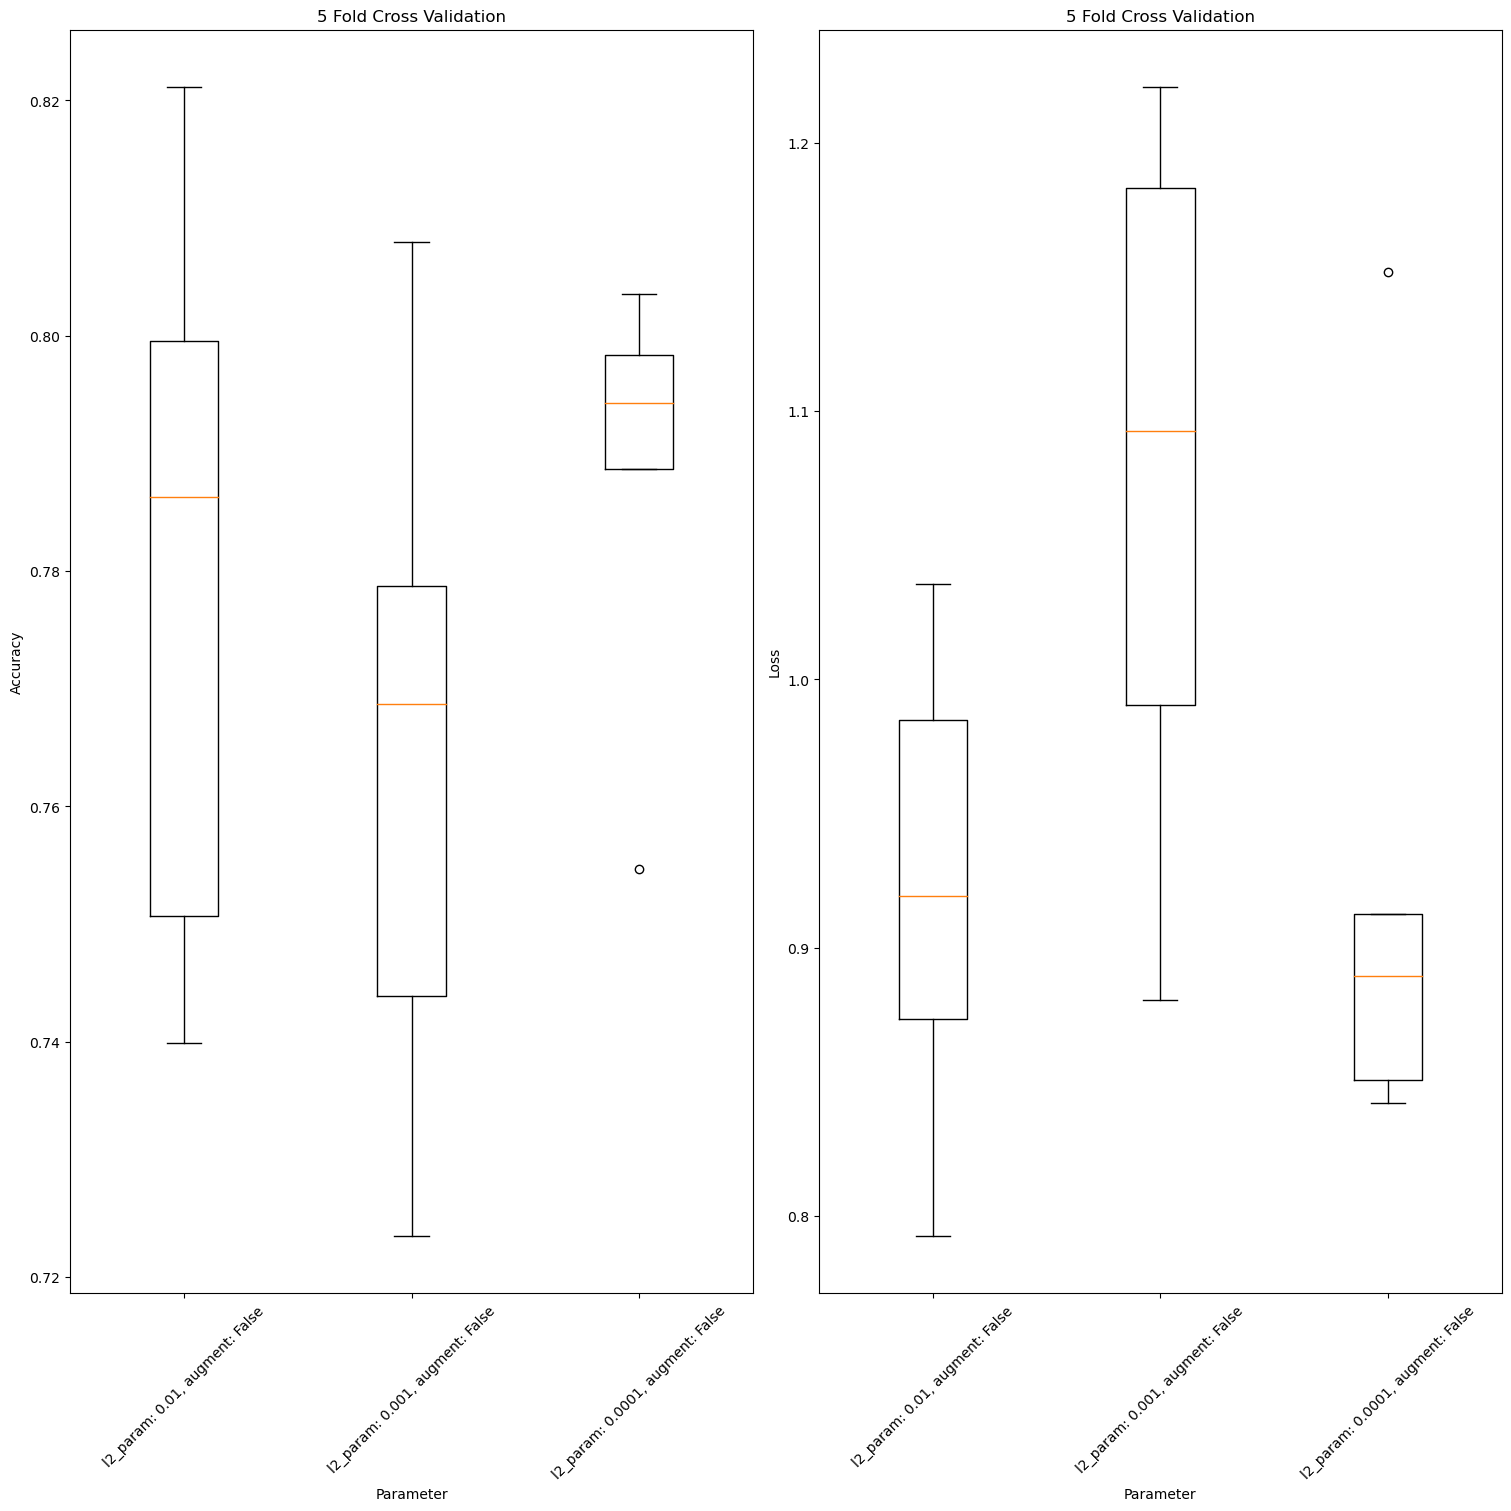

In [8]:
# The following data has been generated with the above custom KFold Cross Validation method
#model_history = {
#    "last_layer_param: 512": [{"fold": 0, "loss": 0.9580041766166687, "acc": 0.6450580358505249}, {"fold": 1, "loss": 0.8243932127952576, "acc": 0.685874342918396}, {"fold": 2, "loss": 1.3444817066192627, "acc": 0.5246098637580872}, {"fold": 3, "loss": 0.9893543124198914, "acc": 0.6194477677345276}, {"fold": 4, "loss": 0.8950880169868469, "acc": 0.6618647575378418}],
#    "last_layer_param: 1024": [{"fold": 0, "loss": 1.002255916595459, "acc": 0.6302521228790283}, {"fold": 1, "loss": 1.0927249193191528, "acc": 0.5918367505073547}, {"fold": 2, "loss": 1.0004750490188599, "acc": 0.6314525604248047}, {"fold": 3, "loss": 0.9172393679618835, "acc": 0.6574629545211792}, {"fold": 4, "loss": 1.024383306503296, "acc": 0.6054421663284302}],
#    "last_layer_param: 2048": [{"fold": 0, "loss": 1.1013964414596558, "acc": 0.5674269795417786}, {"fold": 1, "loss": 0.9457604289054871, "acc": 0.6214485764503479}, {"fold": 2, "loss": 1.1457700729370117, "acc": 0.5774309635162354}, {"fold": 3, "loss": 0.8856483101844788, "acc": 0.6426570415496826}, {"fold": 4, "loss": 0.9397972822189331, "acc": 0.6210483908653259}]
#}
print(model_history)
accuracies = dict()
losses = dict()
for key in model_history.keys():
    accuracies[key] = []
    losses[key] = []
    for entry in model_history[key]:
        losses[key].append(entry["loss"])
        accuracies[key].append(entry["acc"])

fig, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].set_title("5 Fold Cross Validation")
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Parameter")
ax[0].boxplot(accuracies.values())
ax[0].set_xticklabels(accuracies.keys(), rotation=45)
ax[1].set_title("5 Fold Cross Validation")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Parameter")
ax[1].boxplot(losses.values())
ax[1].set_xticklabels(losses.keys(), rotation=45)

fig.set_figheight(15)
fig.set_figwidth(15)

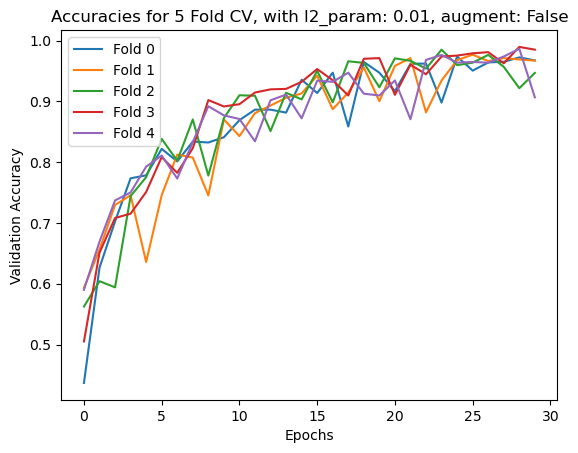

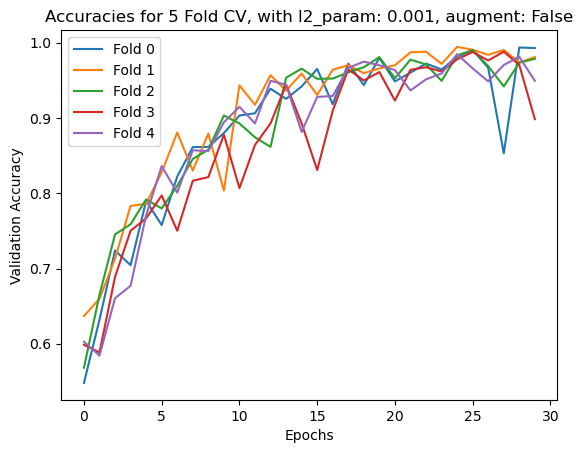

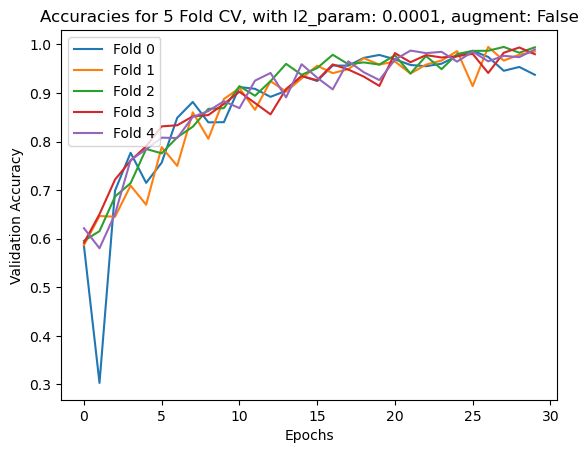

In [9]:
for m_key in model_history:
    for item in model_history.get(m_key):
        for key in item:
            if key == 'history':
                history = item.get('history')
                fold = item.get("fold")
                plt.plot(history.history['val_accuracy'], label=f"Fold {fold}")
    plt.title(f"Accuracies for 5 Fold CV, with {m_key}")
    plt.ylabel("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.legend(loc= 'upper left')
    plt.show()

### Update with GridSearchCV
Apparently the first believe that the model parameters can't be optimized using GridSearchCV was a misperception because `model.get_params()` just did not output the expected parameters... Beause the GridSearchCV implementation does somehow not work with our model and because of the huge effort, we left the above implementation but still provide a version using GridSearchCV which is way more elegant. We believe that it is a bug of GridSearchCV that our model doesn't work with the function because the accuaracy does not improve at all and if we use less layers, it seems to work. For the details, please look at the [Issue on GitHub](https://github.com/scikit-learn/scikit-learn/issues/25825) which we've created for this behavior. 

To still show an example with GridSearchCV we found another model that seems to work so we provided this model along with the GridSearchCV implementation to show the pros of this implementation. 

The new model is a very simple model which experiences overfitting but for our GridSearchCV demo purposes this is okay. 

In [15]:
def create_model_SGD(last_layer_param, augment=True):
    model = Sequential()
    if augment:
        model.add(data_augmentation)
    model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, 3), padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(last_layer_param, activation = 'relu'))
    model.add(Dropout(rate = 0.2))
    model.add(BatchNormalization())
    model.add(Dense(last_layer_param, activation = 'relu'))
    model.add(Dropout(rate = 0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(5, activation = 'softmax'))
    
    # compilation of the model
    
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer='SGD', metrics=['accuracy'])
    
    return model

In [17]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

dataset = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    seed=123,  # for reproducibility
    image_size=(img_size, img_size)
)

images = np.concatenate([x for x, y in dataset], axis=0)
labels = np.concatenate([y for x, y in dataset], axis=0)

param_grid=dict(
    model__last_layer_param=[256, 512, 1024],
    model__augment=[False]
    # model__l2_param=[0.001, 0.0001],
    # model__last_dropout_param=[0.2, 0.3, 0.4]
)

model = KerasClassifier(model=create_model_SGD)

print(model.get_params())

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

grid_result = grid.fit(images, labels, epochs=10)

Found 2666 files belonging to 5 classes.
{'model': <function create_model_SGD at 0x4de8a7910>, 'build_fn': None, 'warm_start': False, 'random_state': None, 'optimizer': 'rmsprop', 'loss': None, 'metrics': None, 'batch_size': None, 'validation_batch_size': None, 'verbose': 1, 'callbacks': None, 'validation_split': 0.0, 'shuffle': True, 'run_eagerly': False, 'epochs': 1, 'class_weight': None}
Epoch 1/10


2023-03-14 10:32:55.481528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 7s 80ms/step - loss: 2.0667 - accuracy: 0.2017
Epoch 2/10
67/67 [==============================] - 4s 61ms/step - loss: 1.6722 - accuracy: 0.2889
Epoch 3/10
67/67 [==============================] - 4s 59ms/step - loss: 1.4881 - accuracy: 0.3865
Epoch 4/10
67/67 [==============================] - 4s 62ms/step - loss: 1.2450 - accuracy: 0.4934
Epoch 5/10
67/67 [==============================] - 4s 62ms/step - loss: 0.9908 - accuracy: 0.6351
Epoch 6/10
67/67 [==============================] - 4s 61ms/step - loss: 0.7256 - accuracy: 0.7514
Epoch 7/10
67/67 [==============================] - 4s 60ms/step - loss: 0.5096 - accuracy: 0.8382
Epoch 8/10
67/67 [==============================] - 4s 59ms/step - loss: 0.3520 - accuracy: 0.9123
Epoch 9/10
67/67 [==============================] - 4s 59ms/step - loss: 0.2622 - accuracy: 0.9348
Epoch 10/10
67/67 [==============================] - 4s 60ms/step - loss: 0.1696 - accuracy: 0.9658


2023-03-14 10:33:38.627936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 26ms/step
Epoch 1/10


2023-03-14 10:33:40.518057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 6s 78ms/step - loss: 2.0305 - accuracy: 0.2082
Epoch 2/10
67/67 [==============================] - 4s 61ms/step - loss: 1.6808 - accuracy: 0.2977
Epoch 3/10
67/67 [==============================] - 4s 60ms/step - loss: 1.4666 - accuracy: 0.3882
Epoch 4/10
67/67 [==============================] - 4s 61ms/step - loss: 1.2384 - accuracy: 0.5002
Epoch 5/10
67/67 [==============================] - 4s 60ms/step - loss: 0.9934 - accuracy: 0.6338
Epoch 6/10
67/67 [==============================] - 4s 60ms/step - loss: 0.7740 - accuracy: 0.7332
Epoch 7/10
67/67 [==============================] - 4s 61ms/step - loss: 0.5489 - accuracy: 0.8354
Epoch 8/10
67/67 [==============================] - 4s 61ms/step - loss: 0.3915 - accuracy: 0.8945
Epoch 9/10
67/67 [==============================] - 4s 60ms/step - loss: 0.2681 - accuracy: 0.9414
Epoch 10/10
67/67 [==============================] - 4s 59ms/step - loss: 0.1817 - accuracy: 0.9681


2023-03-14 10:34:22.922104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 33ms/step
Epoch 1/10


2023-03-14 10:34:25.017956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 6s 78ms/step - loss: 2.0413 - accuracy: 0.2016
Epoch 2/10
67/67 [==============================] - 4s 61ms/step - loss: 1.7378 - accuracy: 0.2874
Epoch 3/10
67/67 [==============================] - 4s 62ms/step - loss: 1.5377 - accuracy: 0.3497
Epoch 4/10
67/67 [==============================] - 4s 61ms/step - loss: 1.3298 - accuracy: 0.4576
Epoch 5/10
67/67 [==============================] - 4s 61ms/step - loss: 1.1473 - accuracy: 0.5710
Epoch 6/10
67/67 [==============================] - 4s 61ms/step - loss: 0.9271 - accuracy: 0.6657
Epoch 7/10
67/67 [==============================] - 4s 62ms/step - loss: 0.7027 - accuracy: 0.7665
Epoch 8/10
67/67 [==============================] - 4s 60ms/step - loss: 0.4870 - accuracy: 0.8514
Epoch 9/10
67/67 [==============================] - 4s 60ms/step - loss: 0.3189 - accuracy: 0.9142
Epoch 10/10
67/67 [==============================] - 4s 61ms/step - loss: 0.2097 - accuracy: 0.9503


2023-03-14 10:35:07.868354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 29ms/step
Epoch 1/10


2023-03-14 10:35:09.805469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 7s 77ms/step - loss: 2.0456 - accuracy: 0.2072
Epoch 2/10
67/67 [==============================] - 4s 64ms/step - loss: 1.6729 - accuracy: 0.2940
Epoch 3/10
67/67 [==============================] - 4s 62ms/step - loss: 1.4492 - accuracy: 0.3952
Epoch 4/10
67/67 [==============================] - 4s 60ms/step - loss: 1.2552 - accuracy: 0.4979
Epoch 5/10
67/67 [==============================] - 4s 64ms/step - loss: 1.0030 - accuracy: 0.6343
Epoch 6/10
67/67 [==============================] - 4s 64ms/step - loss: 0.7704 - accuracy: 0.7304
Epoch 7/10
67/67 [==============================] - 4s 60ms/step - loss: 0.5485 - accuracy: 0.8256
Epoch 8/10
67/67 [==============================] - 4s 60ms/step - loss: 0.3849 - accuracy: 0.8931
Epoch 9/10
67/67 [==============================] - 4s 61ms/step - loss: 0.2449 - accuracy: 0.9428
Epoch 10/10
67/67 [==============================] - 4s 59ms/step - loss: 0.2202 - accuracy: 0.9461


2023-03-14 10:35:53.463822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 26ms/step
Epoch 1/10


2023-03-14 10:35:56.191485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 7s 77ms/step - loss: 2.0839 - accuracy: 0.1955
Epoch 2/10
67/67 [==============================] - 4s 60ms/step - loss: 1.6961 - accuracy: 0.2808
Epoch 3/10
67/67 [==============================] - 4s 60ms/step - loss: 1.4834 - accuracy: 0.3793
Epoch 4/10
67/67 [==============================] - 4s 60ms/step - loss: 1.2054 - accuracy: 0.5171
Epoch 5/10
67/67 [==============================] - 4s 60ms/step - loss: 0.9481 - accuracy: 0.6446
Epoch 6/10
67/67 [==============================] - 4s 60ms/step - loss: 0.7043 - accuracy: 0.7703
Epoch 7/10
67/67 [==============================] - 4s 61ms/step - loss: 0.5046 - accuracy: 0.8542
Epoch 8/10
67/67 [==============================] - 4s 62ms/step - loss: 0.3446 - accuracy: 0.9081
Epoch 9/10
67/67 [==============================] - 4s 61ms/step - loss: 0.2274 - accuracy: 0.9437
Epoch 10/10
67/67 [==============================] - 4s 61ms/step - loss: 0.1493 - accuracy: 0.9695


2023-03-14 10:36:38.627314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 32ms/step
Epoch 1/10


2023-03-14 10:36:40.075230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 6s 78ms/step - loss: 2.1225 - accuracy: 0.2158
Epoch 2/10
67/67 [==============================] - 4s 63ms/step - loss: 1.6142 - accuracy: 0.3340
Epoch 3/10
67/67 [==============================] - 4s 66ms/step - loss: 1.3239 - accuracy: 0.4573
Epoch 4/10
67/67 [==============================] - 4s 63ms/step - loss: 0.9652 - accuracy: 0.6487
Epoch 5/10
67/67 [==============================] - 4s 63ms/step - loss: 0.6741 - accuracy: 0.7739
Epoch 6/10
67/67 [==============================] - 4s 62ms/step - loss: 0.4275 - accuracy: 0.8738
Epoch 7/10
67/67 [==============================] - 4s 64ms/step - loss: 0.2873 - accuracy: 0.9273
Epoch 8/10
67/67 [==============================] - 4s 62ms/step - loss: 0.1926 - accuracy: 0.9578
Epoch 9/10
67/67 [==============================] - 4s 63ms/step - loss: 0.1153 - accuracy: 0.9789
Epoch 10/10
67/67 [==============================] - 4s 62ms/step - loss: 0.0810 - accuracy: 0.9869


2023-03-14 10:37:24.484224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 29ms/step
Epoch 1/10


2023-03-14 10:37:25.928989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 7s 84ms/step - loss: 2.1424 - accuracy: 0.2011
Epoch 2/10
67/67 [==============================] - 4s 64ms/step - loss: 1.6396 - accuracy: 0.3244
Epoch 3/10
67/67 [==============================] - 4s 64ms/step - loss: 1.3914 - accuracy: 0.4229
Epoch 4/10
67/67 [==============================] - 4s 63ms/step - loss: 1.0553 - accuracy: 0.6123
Epoch 5/10
67/67 [==============================] - 5s 67ms/step - loss: 0.7521 - accuracy: 0.7459
Epoch 6/10
67/67 [==============================] - 4s 62ms/step - loss: 0.5297 - accuracy: 0.8331
Epoch 7/10
67/67 [==============================] - 4s 63ms/step - loss: 0.3315 - accuracy: 0.9114
Epoch 8/10
67/67 [==============================] - 4s 63ms/step - loss: 0.2000 - accuracy: 0.9592
Epoch 9/10
67/67 [==============================] - 4s 65ms/step - loss: 0.1230 - accuracy: 0.9780
Epoch 10/10
67/67 [==============================] - 4s 63ms/step - loss: 0.0971 - accuracy: 0.9803


2023-03-14 10:38:11.310000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 29ms/step
Epoch 1/10


2023-03-14 10:38:12.901879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 7s 83ms/step - loss: 2.1814 - accuracy: 0.2039
Epoch 2/10
67/67 [==============================] - 4s 64ms/step - loss: 1.6824 - accuracy: 0.3010
Epoch 3/10
67/67 [==============================] - 4s 64ms/step - loss: 1.4206 - accuracy: 0.4210
Epoch 4/10
67/67 [==============================] - 4s 63ms/step - loss: 1.1577 - accuracy: 0.5518
Epoch 5/10
67/67 [==============================] - 4s 64ms/step - loss: 0.8751 - accuracy: 0.6699
Epoch 6/10
67/67 [==============================] - 4s 67ms/step - loss: 0.5738 - accuracy: 0.8139
Epoch 7/10
67/67 [==============================] - 4s 63ms/step - loss: 0.3731 - accuracy: 0.8964
Epoch 8/10
67/67 [==============================] - 4s 63ms/step - loss: 0.2308 - accuracy: 0.9470
Epoch 9/10
67/67 [==============================] - 4s 66ms/step - loss: 0.1384 - accuracy: 0.9789
Epoch 10/10
67/67 [==============================] - 4s 63ms/step - loss: 0.1174 - accuracy: 0.9747


2023-03-14 10:38:58.392598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 31ms/step
Epoch 1/10


2023-03-14 10:39:00.084382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 7s 79ms/step - loss: 2.2205 - accuracy: 0.1908
Epoch 2/10
67/67 [==============================] - 4s 65ms/step - loss: 1.6832 - accuracy: 0.3043
Epoch 3/10
67/67 [==============================] - 4s 63ms/step - loss: 1.4224 - accuracy: 0.4210
Epoch 4/10
67/67 [==============================] - 5s 67ms/step - loss: 1.1213 - accuracy: 0.5724
Epoch 5/10
67/67 [==============================] - 4s 63ms/step - loss: 0.8068 - accuracy: 0.7140
Epoch 6/10
67/67 [==============================] - 4s 64ms/step - loss: 0.5753 - accuracy: 0.8265
Epoch 7/10
67/67 [==============================] - 4s 64ms/step - loss: 0.3659 - accuracy: 0.8992
Epoch 8/10
67/67 [==============================] - 4s 64ms/step - loss: 0.2574 - accuracy: 0.9325
Epoch 9/10
67/67 [==============================] - 4s 63ms/step - loss: 0.1731 - accuracy: 0.9648
Epoch 10/10
67/67 [==============================] - 4s 63ms/step - loss: 0.1088 - accuracy: 0.9836


2023-03-14 10:39:45.413706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 30ms/step
Epoch 1/10


2023-03-14 10:39:46.966043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 8s 97ms/step - loss: 2.1830 - accuracy: 0.1960
Epoch 2/10
67/67 [==============================] - 6s 84ms/step - loss: 1.6643 - accuracy: 0.3179
Epoch 3/10
67/67 [==============================] - 5s 75ms/step - loss: 1.3957 - accuracy: 0.4402
Epoch 4/10
67/67 [==============================] - 5s 77ms/step - loss: 1.0890 - accuracy: 0.5720
Epoch 5/10
67/67 [==============================] - 5s 76ms/step - loss: 0.7959 - accuracy: 0.7239
Epoch 6/10
67/67 [==============================] - 5s 73ms/step - loss: 0.5429 - accuracy: 0.8247
Epoch 7/10
67/67 [==============================] - 5s 73ms/step - loss: 0.3525 - accuracy: 0.9015
Epoch 8/10
67/67 [==============================] - 5s 73ms/step - loss: 0.2387 - accuracy: 0.9409
Epoch 9/10
67/67 [==============================] - 5s 74ms/step - loss: 0.1669 - accuracy: 0.9672
Epoch 10/10
67/67 [==============================] - 5s 74ms/step - loss: 0.1139 - accuracy: 0.9770


2023-03-14 10:40:40.476281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 36ms/step
Epoch 1/10


2023-03-14 10:40:42.226273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 10s 115ms/step - loss: 2.2755 - accuracy: 0.1975
Epoch 2/10
67/67 [==============================] - 6s 96ms/step - loss: 1.7277 - accuracy: 0.3189
Epoch 3/10
67/67 [==============================] - 6s 94ms/step - loss: 1.3673 - accuracy: 0.4573
Epoch 4/10
67/67 [==============================] - 6s 88ms/step - loss: 1.0053 - accuracy: 0.6140
Epoch 5/10
67/67 [==============================] - 6s 88ms/step - loss: 0.6975 - accuracy: 0.7645
Epoch 6/10
67/67 [==============================] - 6s 88ms/step - loss: 0.4508 - accuracy: 0.8598
Epoch 7/10
67/67 [==============================] - 6s 91ms/step - loss: 0.2871 - accuracy: 0.9231
Epoch 8/10
67/67 [==============================] - 6s 90ms/step - loss: 0.1786 - accuracy: 0.9629
Epoch 9/10
67/67 [==============================] - 6s 89ms/step - loss: 0.1168 - accuracy: 0.9798
Epoch 10/10
67/67 [==============================] - 6s 87ms/step - loss: 0.0870 - accuracy: 0.9869


2023-03-14 10:41:45.962549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 48ms/step
Epoch 1/10


2023-03-14 10:41:47.748229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 10s 123ms/step - loss: 2.2789 - accuracy: 0.1917
Epoch 2/10
67/67 [==============================] - 6s 90ms/step - loss: 1.6800 - accuracy: 0.3315
Epoch 3/10
67/67 [==============================] - 6s 88ms/step - loss: 1.3653 - accuracy: 0.4594
Epoch 4/10
67/67 [==============================] - 6s 88ms/step - loss: 0.9568 - accuracy: 0.6437
Epoch 5/10
67/67 [==============================] - 6s 89ms/step - loss: 0.6156 - accuracy: 0.7975
Epoch 6/10
67/67 [==============================] - 6s 91ms/step - loss: 0.3813 - accuracy: 0.8922
Epoch 7/10
67/67 [==============================] - 6s 96ms/step - loss: 0.2163 - accuracy: 0.9512
Epoch 8/10
67/67 [==============================] - 6s 92ms/step - loss: 0.1443 - accuracy: 0.9677
Epoch 9/10
67/67 [==============================] - 6s 89ms/step - loss: 0.1031 - accuracy: 0.9808
Epoch 10/10
67/67 [==============================] - 6s 93ms/step - loss: 0.0542 - accuracy: 0.9972


2023-03-14 10:42:52.181553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 40ms/step
Epoch 1/10


2023-03-14 10:42:54.006372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 10s 124ms/step - loss: 2.2559 - accuracy: 0.2166
Epoch 2/10
67/67 [==============================] - 6s 94ms/step - loss: 1.7169 - accuracy: 0.3024
Epoch 3/10
67/67 [==============================] - 6s 95ms/step - loss: 1.3080 - accuracy: 0.4749
Epoch 4/10
67/67 [==============================] - 6s 92ms/step - loss: 0.9580 - accuracy: 0.6535
Epoch 5/10
67/67 [==============================] - 6s 91ms/step - loss: 0.6564 - accuracy: 0.7726
Epoch 6/10
67/67 [==============================] - 6s 91ms/step - loss: 0.4022 - accuracy: 0.8922
Epoch 7/10
67/67 [==============================] - 6s 88ms/step - loss: 0.2370 - accuracy: 0.9353
Epoch 8/10
67/67 [==============================] - 6s 89ms/step - loss: 0.1573 - accuracy: 0.9658
Epoch 9/10
67/67 [==============================] - 6s 94ms/step - loss: 0.0969 - accuracy: 0.9817
Epoch 10/10
67/67 [==============================] - 6s 88ms/step - loss: 0.0708 - accuracy: 0.9902


2023-03-14 10:43:58.719009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 34ms/step
Epoch 1/10


2023-03-14 10:44:00.453348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 9s 118ms/step - loss: 2.2764 - accuracy: 0.2105
Epoch 2/10
67/67 [==============================] - 6s 91ms/step - loss: 1.6412 - accuracy: 0.3371
Epoch 3/10
67/67 [==============================] - 6s 91ms/step - loss: 1.2954 - accuracy: 0.4730
Epoch 4/10
67/67 [==============================] - 6s 90ms/step - loss: 0.9194 - accuracy: 0.6568
Epoch 5/10
67/67 [==============================] - 6s 89ms/step - loss: 0.6058 - accuracy: 0.7979
Epoch 6/10
67/67 [==============================] - 6s 90ms/step - loss: 0.4029 - accuracy: 0.8767
Epoch 7/10
67/67 [==============================] - 6s 90ms/step - loss: 0.2669 - accuracy: 0.9241
Epoch 8/10
67/67 [==============================] - 6s 88ms/step - loss: 0.1706 - accuracy: 0.9616
Epoch 9/10
67/67 [==============================] - 6s 90ms/step - loss: 0.1072 - accuracy: 0.9803
Epoch 10/10
67/67 [==============================] - 6s 89ms/step - loss: 0.0837 - accuracy: 0.9873


2023-03-14 10:45:03.904258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 39ms/step
Epoch 1/10


2023-03-14 10:45:05.800658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 9s 119ms/step - loss: 2.2651 - accuracy: 0.1946
Epoch 2/10
67/67 [==============================] - 6s 91ms/step - loss: 1.6563 - accuracy: 0.3310
Epoch 3/10
67/67 [==============================] - 6s 93ms/step - loss: 1.2879 - accuracy: 0.4815
Epoch 4/10
67/67 [==============================] - 6s 92ms/step - loss: 0.8787 - accuracy: 0.6878
Epoch 5/10
67/67 [==============================] - 6s 89ms/step - loss: 0.6180 - accuracy: 0.8045
Epoch 6/10
67/67 [==============================] - 6s 89ms/step - loss: 0.4013 - accuracy: 0.8828
Epoch 7/10
67/67 [==============================] - 6s 88ms/step - loss: 0.2399 - accuracy: 0.9339
Epoch 8/10
67/67 [==============================] - 6s 89ms/step - loss: 0.1403 - accuracy: 0.9705
Epoch 9/10
67/67 [==============================] - 6s 90ms/step - loss: 0.0965 - accuracy: 0.9873
Epoch 10/10
67/67 [==============================] - 6s 89ms/step - loss: 0.0829 - accuracy: 0.9892


2023-03-14 10:46:09.464477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 39ms/step
Epoch 1/10


2023-03-14 10:46:16.243384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 9s 86ms/step - loss: 2.0559 - accuracy: 0.1943
Epoch 2/10
84/84 [==============================] - 5s 62ms/step - loss: 1.6727 - accuracy: 0.2851
Epoch 3/10
84/84 [==============================] - 5s 64ms/step - loss: 1.5024 - accuracy: 0.3631
Epoch 4/10
84/84 [==============================] - 5s 63ms/step - loss: 1.3458 - accuracy: 0.4437
Epoch 5/10
84/84 [==============================] - 5s 61ms/step - loss: 1.1019 - accuracy: 0.5859
Epoch 6/10
84/84 [==============================] - 5s 60ms/step - loss: 0.8700 - accuracy: 0.6812
Epoch 7/10
84/84 [==============================] - 5s 61ms/step - loss: 0.6516 - accuracy: 0.7772
Epoch 8/10
84/84 [==============================] - 5s 59ms/step - loss: 0.4867 - accuracy: 0.8507
Epoch 9/10
84/84 [==============================] - 5s 61ms/step - loss: 0.3244 - accuracy: 0.9171
Epoch 10/10
84/84 [==============================] - 5s 61ms/step - loss: 0.2439 - accuracy: 0.9370


In [21]:
grid.best_params_

{'model__augment': False, 'model__last_layer_param': 256}

We also tried another GridSearchCV implementation that uses tf.data.Dataset directly: [TensorCross](https://github.com/franneck94/TensorCross). Our model works with this implementation so we provide an example using this method as well. At first, TensorCross was not compatible with tensorflow-macos which we've also created a [GitHub Issue](https://github.com/franneck94/TensorCross/issues/45) for, that has been fixed very quickly so we were able to use the library. 

In [7]:
from tensorcross.model_selection import GridSearchCV

dataset = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    seed=123,  # for reproducibility
    image_size=(img_size, img_size)
)
param_grid=dict(
    # last_layer_param=[256, 512, 1024],
    l2_param=[0.01, 0.001, 0.0001],
    augment=[False],
    # last_dropout_param=[0.2, 0.3, 0.4]
)
grid_search_cv = GridSearchCV(
    model_fn=create_model,
    param_grid=param_grid,
    n_folds=5,
)

grid_search_cv.fit(
    dataset=dataset,
    epochs=20,
)

Found 2666 files belonging to 5 classes.
Epoch 1/10


2023-03-14 11:12:37.606922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 14.4288 - accuracy: 0.3864

2023-03-14 11:12:40.620400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 4s 59ms/step - loss: 14.4288 - accuracy: 0.3864 - val_loss: 6.3142 - val_accuracy: 0.5290
Epoch 2/10
56/56 [==============================] - 3s 53ms/step - loss: 5.8444 - accuracy: 0.5616 - val_loss: 5.6583 - val_accuracy: 0.4074
Epoch 3/10
56/56 [==============================] - 3s 52ms/step - loss: 5.1285 - accuracy: 0.5915 - val_loss: 4.9360 - val_accuracy: 0.5647
Epoch 4/10
56/56 [==============================] - 3s 52ms/step - loss: 4.5907 - accuracy: 0.6130 - val_loss: 4.2930 - val_accuracy: 0.6685
Epoch 5/10
56/56 [==============================] - 3s 52ms/step - loss: 4.1132 - accuracy: 0.6621 - val_loss: 3.9217 - val_accuracy: 0.6953
Epoch 6/10
56/56 [==============================] - 3s 52ms/step - loss: 3.7315 - accuracy: 0.7011 - val_loss: 3.5650 - val_accuracy: 0.7065
Epoch 7/10
56/56 [==============================] - 3s 52ms/step - loss: 3.4333 - accuracy: 0.7203 - val_loss: 3.3327 - val_accuracy: 0.7333
Epoch 8/10
56/56 [=====

2023-03-14 11:13:08.661868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 15.9303 - accuracy: 0.3689

2023-03-14 11:13:11.796013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 4s 61ms/step - loss: 15.9303 - accuracy: 0.3689 - val_loss: 6.4187 - val_accuracy: 0.4933
Epoch 2/10
56/56 [==============================] - 3s 55ms/step - loss: 5.9387 - accuracy: 0.5339 - val_loss: 5.7438 - val_accuracy: 0.5670
Epoch 3/10
56/56 [==============================] - 3s 55ms/step - loss: 5.3183 - accuracy: 0.5542 - val_loss: 5.0085 - val_accuracy: 0.5971
Epoch 4/10
56/56 [==============================] - 3s 55ms/step - loss: 4.7702 - accuracy: 0.6011 - val_loss: 4.5446 - val_accuracy: 0.6417
Epoch 5/10
56/56 [==============================] - 3s 55ms/step - loss: 4.3064 - accuracy: 0.6492 - val_loss: 4.2324 - val_accuracy: 0.6429
Epoch 6/10
56/56 [==============================] - 3s 55ms/step - loss: 3.9505 - accuracy: 0.6684 - val_loss: 3.8367 - val_accuracy: 0.6864
Epoch 7/10
56/56 [==============================] - 3s 55ms/step - loss: 3.6221 - accuracy: 0.7040 - val_loss: 3.5111 - val_accuracy: 0.7232
Epoch 8/10
56/56 [=====

2023-03-14 11:13:40.919608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/56 [============================>.] - ETA: 0s - loss: 15.8728 - accuracy: 0.4017

2023-03-14 11:13:43.859220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 4s 59ms/step - loss: 15.7037 - accuracy: 0.4051 - val_loss: 6.3728 - val_accuracy: 0.5492
Epoch 2/10
56/56 [==============================] - 3s 54ms/step - loss: 5.9140 - accuracy: 0.5608 - val_loss: 5.5600 - val_accuracy: 0.6018
Epoch 3/10
56/56 [==============================] - 3s 54ms/step - loss: 5.2070 - accuracy: 0.6027 - val_loss: 5.0017 - val_accuracy: 0.6167
Epoch 4/10
56/56 [==============================] - 3s 54ms/step - loss: 4.6344 - accuracy: 0.6585 - val_loss: 4.4669 - val_accuracy: 0.6636
Epoch 5/10
56/56 [==============================] - 3s 54ms/step - loss: 4.2174 - accuracy: 0.6842 - val_loss: 4.1980 - val_accuracy: 0.5915
Epoch 6/10
56/56 [==============================] - 3s 54ms/step - loss: 3.8929 - accuracy: 0.7031 - val_loss: 3.8764 - val_accuracy: 0.6613
Epoch 7/10
56/56 [==============================] - 3s 55ms/step - loss: 3.6028 - accuracy: 0.7121 - val_loss: 3.5083 - val_accuracy: 0.7368
Epoch 8/10
56/56 [=====

2023-03-14 11:14:13.007927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 10.4920 - accuracy: 0.4028

2023-03-14 11:14:16.100869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 4s 59ms/step - loss: 10.4920 - accuracy: 0.4028 - val_loss: 1.7336 - val_accuracy: 0.5536
Epoch 2/10
56/56 [==============================] - 3s 52ms/step - loss: 1.6240 - accuracy: 0.5876 - val_loss: 1.7132 - val_accuracy: 0.5000
Epoch 3/10
56/56 [==============================] - 3s 52ms/step - loss: 1.5444 - accuracy: 0.6011 - val_loss: 1.4284 - val_accuracy: 0.6830
Epoch 4/10
56/56 [==============================] - 3s 52ms/step - loss: 1.4219 - accuracy: 0.6621 - val_loss: 1.4180 - val_accuracy: 0.6306
Epoch 5/10
56/56 [==============================] - 3s 51ms/step - loss: 1.3358 - accuracy: 0.6915 - val_loss: 1.3261 - val_accuracy: 0.6830
Epoch 6/10
56/56 [==============================] - 3s 52ms/step - loss: 1.2429 - accuracy: 0.7243 - val_loss: 1.4018 - val_accuracy: 0.6674
Epoch 7/10
56/56 [==============================] - 3s 52ms/step - loss: 1.2224 - accuracy: 0.7266 - val_loss: 1.1621 - val_accuracy: 0.7690
Epoch 8/10
56/56 [=====

2023-03-14 11:14:43.934421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 9.6585 - accuracy: 0.4011

2023-03-14 11:14:47.237905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 4s 66ms/step - loss: 9.6585 - accuracy: 0.4011 - val_loss: 1.8236 - val_accuracy: 0.5413
Epoch 2/10
56/56 [==============================] - 3s 56ms/step - loss: 1.6573 - accuracy: 0.5706 - val_loss: 1.6455 - val_accuracy: 0.6060
Epoch 3/10
56/56 [==============================] - 3s 55ms/step - loss: 1.4529 - accuracy: 0.6435 - val_loss: 1.4843 - val_accuracy: 0.6138
Epoch 4/10
56/56 [==============================] - 3s 55ms/step - loss: 1.4754 - accuracy: 0.6254 - val_loss: 1.4506 - val_accuracy: 0.6384
Epoch 5/10
56/56 [==============================] - 3s 55ms/step - loss: 1.3670 - accuracy: 0.6802 - val_loss: 1.2564 - val_accuracy: 0.7522
Epoch 6/10
56/56 [==============================] - 3s 54ms/step - loss: 1.2651 - accuracy: 0.7130 - val_loss: 1.3713 - val_accuracy: 0.6585
Epoch 7/10
56/56 [==============================] - 3s 54ms/step - loss: 1.2746 - accuracy: 0.7153 - val_loss: 1.3019 - val_accuracy: 0.7132
Epoch 8/10
56/56 [======

2023-03-14 11:15:16.293472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/56 [============================>.] - ETA: 0s - loss: 8.8221 - accuracy: 0.3938

2023-03-14 11:15:19.374068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 4s 63ms/step - loss: 8.7004 - accuracy: 0.3968 - val_loss: 1.8426 - val_accuracy: 0.4531
Epoch 2/10
56/56 [==============================] - 3s 54ms/step - loss: 1.7065 - accuracy: 0.5212 - val_loss: 1.7041 - val_accuracy: 0.5618
Epoch 3/10
56/56 [==============================] - 3s 53ms/step - loss: 1.5896 - accuracy: 0.5865 - val_loss: 1.5488 - val_accuracy: 0.6201
Epoch 4/10
56/56 [==============================] - 3s 54ms/step - loss: 1.4433 - accuracy: 0.6267 - val_loss: 1.4500 - val_accuracy: 0.6682
Epoch 5/10
56/56 [==============================] - 3s 53ms/step - loss: 1.3311 - accuracy: 0.6791 - val_loss: 1.5969 - val_accuracy: 0.5892
Epoch 6/10
56/56 [==============================] - 3s 53ms/step - loss: 1.2907 - accuracy: 0.6897 - val_loss: 1.3968 - val_accuracy: 0.6419
Epoch 7/10
56/56 [==============================] - 3s 53ms/step - loss: 1.2160 - accuracy: 0.7193 - val_loss: 1.2772 - val_accuracy: 0.7071
Epoch 8/10
56/56 [======

2023-03-14 11:15:48.019314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 10.2656 - accuracy: 0.3537

2023-03-14 11:15:51.416192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 4s 64ms/step - loss: 10.2656 - accuracy: 0.3537 - val_loss: 1.2597 - val_accuracy: 0.4509
Epoch 2/10
56/56 [==============================] - 3s 53ms/step - loss: 1.1557 - accuracy: 0.5492 - val_loss: 1.0182 - val_accuracy: 0.6083
Epoch 3/10
56/56 [==============================] - 3s 52ms/step - loss: 0.9948 - accuracy: 0.6158 - val_loss: 1.0234 - val_accuracy: 0.6496
Epoch 4/10
56/56 [==============================] - 3s 52ms/step - loss: 0.9645 - accuracy: 0.6350 - val_loss: 1.0979 - val_accuracy: 0.5536
Epoch 5/10
56/56 [==============================] - 3s 52ms/step - loss: 0.8981 - accuracy: 0.6718 - val_loss: 0.9174 - val_accuracy: 0.6964
Epoch 6/10
56/56 [==============================] - 3s 51ms/step - loss: 0.8304 - accuracy: 0.7000 - val_loss: 0.8755 - val_accuracy: 0.7098
Epoch 7/10
56/56 [==============================] - 3s 51ms/step - loss: 0.7909 - accuracy: 0.7254 - val_loss: 1.2654 - val_accuracy: 0.5625
Epoch 8/10
56/56 [=====

2023-03-14 11:16:19.885442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 9.1255 - accuracy: 0.3684

2023-03-14 11:16:23.315730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 5s 66ms/step - loss: 9.1255 - accuracy: 0.3684 - val_loss: 1.2572 - val_accuracy: 0.5513
Epoch 2/10
56/56 [==============================] - 3s 55ms/step - loss: 1.1515 - accuracy: 0.5356 - val_loss: 1.3136 - val_accuracy: 0.4375
Epoch 3/10
56/56 [==============================] - 3s 55ms/step - loss: 1.0456 - accuracy: 0.5960 - val_loss: 0.9694 - val_accuracy: 0.6607
Epoch 4/10
56/56 [==============================] - 3s 54ms/step - loss: 0.9437 - accuracy: 0.6452 - val_loss: 0.8858 - val_accuracy: 0.7009
Epoch 5/10
56/56 [==============================] - 3s 55ms/step - loss: 0.9104 - accuracy: 0.6718 - val_loss: 0.8655 - val_accuracy: 0.7042
Epoch 6/10
56/56 [==============================] - 3s 55ms/step - loss: 0.7818 - accuracy: 0.7254 - val_loss: 0.7843 - val_accuracy: 0.7366
Epoch 7/10
56/56 [==============================] - 3s 55ms/step - loss: 0.7304 - accuracy: 0.7548 - val_loss: 0.7337 - val_accuracy: 0.7612
Epoch 8/10
56/56 [======

2023-03-14 11:16:52.394750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 9.2180 - accuracy: 0.3834

2023-03-14 11:16:55.529902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 4s 62ms/step - loss: 9.2180 - accuracy: 0.3834 - val_loss: 1.2835 - val_accuracy: 0.5309
Epoch 2/10
56/56 [==============================] - 3s 54ms/step - loss: 1.1239 - accuracy: 0.5631 - val_loss: 1.1198 - val_accuracy: 0.6007
Epoch 3/10
56/56 [==============================] - 3s 54ms/step - loss: 1.0733 - accuracy: 0.5776 - val_loss: 1.0906 - val_accuracy: 0.6098
Epoch 4/10
56/56 [==============================] - 3s 54ms/step - loss: 1.0113 - accuracy: 0.6183 - val_loss: 1.0062 - val_accuracy: 0.6533
Epoch 5/10
56/56 [==============================] - 3s 54ms/step - loss: 0.9075 - accuracy: 0.6473 - val_loss: 0.9283 - val_accuracy: 0.6888
Epoch 6/10
56/56 [==============================] - 3s 54ms/step - loss: 0.8168 - accuracy: 0.6948 - val_loss: 0.9044 - val_accuracy: 0.6773
Epoch 7/10
56/56 [==============================] - 3s 54ms/step - loss: 0.7805 - accuracy: 0.7299 - val_loss: 0.8251 - val_accuracy: 0.7140
Epoch 8/10
56/56 [======

In [8]:
grid_search_cv.summary()


-------------------------------------------------------------------------------------------------
Best score: [0.7522322  0.78013396 0.7768879 ] using params: {'augment': False, 'l2_param': 0.01}
-------------------------------------------------------------------------------------------------
Idx: 0 - Score: [0.7522322  0.78013396 0.7768879 ] with param: {'augment': False, 'l2_param': 0.01}
Idx: 1 - Score: [0.78794646 0.78459823 0.735698  ] with param: {'augment': False, 'l2_param': 0.001}
Idx: 2 - Score: [0.7433036  0.72656256 0.75057214] with param: {'augment': False, 'l2_param': 0.0001}
-------------------------------------------------------------------------------------------------



"\n-------------------------------------------------------------------------------------------------\nBest score: [0.7522322  0.78013396 0.7768879 ] using params: {'augment': False, 'l2_param': 0.01}\n-------------------------------------------------------------------------------------------------Idx: 0 - Score: [0.7522322  0.78013396 0.7768879 ] with param: {'augment': False, 'l2_param': 0.01}Idx: 1 - Score: [0.78794646 0.78459823 0.735698  ] with param: {'augment': False, 'l2_param': 0.001}Idx: 2 - Score: [0.7433036  0.72656256 0.75057214] with param: {'augment': False, 'l2_param': 0.0001}-------------------------------------------------------------------------------------------------\n"

## Training the Model

In [10]:
model = create_model(augment=True)
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d_75 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                

In [11]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30


2023-03-14 10:25:06.230708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - ETA: 0s - loss: 1.4928 - accuracy: 0.3891

2023-03-14 10:25:16.910140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 12s 153ms/step - loss: 1.4928 - accuracy: 0.3891 - val_loss: 1.5994 - val_accuracy: 0.3677
Epoch 2/30
67/67 [==============================] - 9s 129ms/step - loss: 1.1786 - accuracy: 0.5265 - val_loss: 1.4078 - val_accuracy: 0.4597
Epoch 3/30
67/67 [==============================] - 9s 127ms/step - loss: 1.0738 - accuracy: 0.5663 - val_loss: 1.2420 - val_accuracy: 0.5009
Epoch 4/30
67/67 [==============================] - 8s 125ms/step - loss: 0.9689 - accuracy: 0.6123 - val_loss: 0.8973 - val_accuracy: 0.6454
Epoch 5/30
67/67 [==============================] - 9s 127ms/step - loss: 0.9433 - accuracy: 0.6296 - val_loss: 0.8969 - val_accuracy: 0.6660
Epoch 6/30
67/67 [==============================] - 9s 129ms/step - loss: 0.8574 - accuracy: 0.6667 - val_loss: 0.8384 - val_accuracy: 0.6660
Epoch 7/30
67/67 [==============================] - 9s 127ms/step - loss: 0.8409 - accuracy: 0.6723 - val_loss: 0.7939 - val_accuracy: 0.6998
Epoch 8/30
67/67

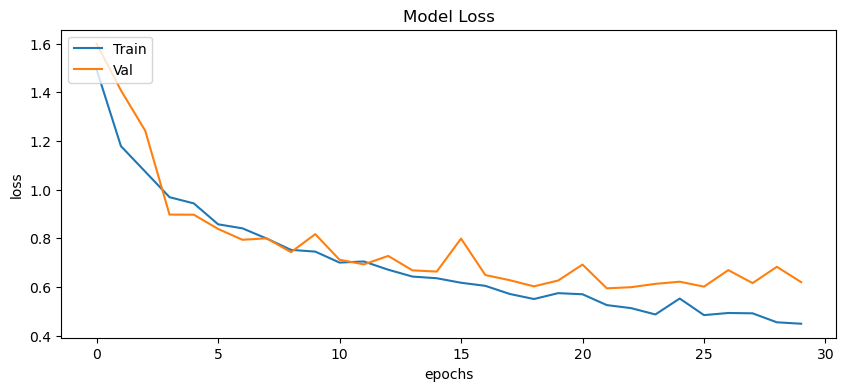

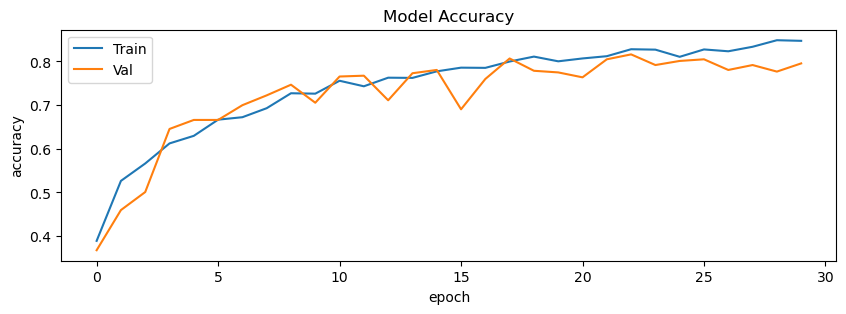

In [12]:
%run rueegg_wissiak_model_visualization.ipynb

In [13]:
model.evaluate(test_ds)

79/79 [==============================] - 2s 18ms/step - loss: 0.6012 - accuracy: 0.7967


[0.6011980772018433, 0.7967186570167542]

## Confusion Matrix

In [34]:
from sklearn import metrics

true_labels = np.array([], dtype=np.uint8)
pred_labels = np.array([], dtype=np.uint8)
for images_batch, true_labels_batch in test_ds:
   pred_labels_batch = np.argmax(model.predict(images_batch), axis=-1)
   true_labels = np.concatenate([true_labels, true_labels_batch])
   pred_labels = np.concatenate([pred_labels, pred_labels_batch])

confusion_matrix = metrics.confusion_matrix(y_true=true_labels, y_pred=pred_labels)
display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=test_ds.class_names)
display.plot()
plt.show()

NotFittedError: Estimator needs to be fit before `predict` can be called

# Summary
This project as exciting as it was challenging. It made us really try out numerous ways on how to tweak both performance in the sense of speed and of model accuracy. It is interesting how a small change can have a huge impact on the model's learning behavior. We've also extensively dealt with the over- and underfitting effects which consolidated our understanding on how and when to use Regularization and Generalization optimizations. 

In summary, creating a model with tensorflow is very easy and convenient but creating a performant model can be an overwhelming and time consuming process that can be frustrating at some point. But seeing the results of a successful improvement, on the other hand, is very satisfactory. The biggest difficulty in our opinion is to not loose the overview of the data handling. 

## Outlook
As a wrap-up we'd like to give a short outlook on what could be further steps to improve the model or to take the model into production.

### Export and Reuse
Tensorflow allows to export the weights of a trained model. In this way a new model can be initialized using the saved weights and can be used directly to make predictions on unseen data. This would be the method we'd use if we'd take this model to some productive use. 